# 1. Import

In [1]:
# Basic Library
import os
import pandas as pd
import numpy as np
import pickle
from itertools import permutations, combinations
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, QuantileTransformer

# HP Tuning
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from optuna.visualization import plot_contour, plot_optimization_history
from optuna.visualization import plot_parallel_coordinate, plot_slice, plot_param_importances

# Modeling
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from lightgbm import LGBMRegressor
import xgboost as xgb
from catboost import CatBoostRegressor, Pool

In [2]:
def create_dir(dir):
    if not os.path.exists(dir):
        os.makedirs(dir)
        print("Created Directory :", dir)
    else:
        print("Directory already existed :", dir)
create_dir("../pickle")
create_dir("../model")
create_dir("../submission")

Directory already existed : ../pickle
Directory already existed : ../model
Directory already existed : ../submission


In [3]:
train = pd.read_csv("../data/train_f1.csv")
test = pd.read_csv("../data/test_f1.csv")
submission = pd.read_csv("../data/sample_submission.csv")

In [4]:
rows_train = train.shape[0] # 주어진 train data의 row 수
rows_test = test.shape[0] # 주어진 test data의 row 수
num_trial = 100 # 파라미터 튜닝을 몇 번 진행하는지의 수
splits_hp = 5 # 파라미터 튜닝을 진행할 때의 kfold 수
splits_tr = 20 # 모델 트레이닝을 진행할 때의 kfold 수
basic_seed = 42 # default seed
num_seed_hp = 3 # 파라미터 튜닝 seed 개수
num_seed_tr = 10 # 트레이닝 seed 개수
sel_seed = 3 # 선택할 seed 개수

In [5]:
pred_dict = {}
pred_test_dict = {}

# 2. Catboost

In [6]:
train_x = train.drop(['Target'], axis=1) # 데이터 나누기
train_y = train['Target']
test_x = test.copy()

In [7]:
cat_features = ["Gender"]

In [8]:
def cat_objective(trial: Trial) -> float:
    score_hp = []
    for seed_hp in np.random.randint(0, 1000, num_seed_hp):
        params_cat = {
            "cat_features": cat_features,
            "random_state": seed_hp,
            "loss_function": "MAE",
            "eval_metric": "MAE",
            "iterations": 10000,
            "od_type": "iter",
            "od_wait": trial.suggest_int("od_wait", 50, 500),
            "learning_rate": trial.suggest_uniform("learning_rate", 1e-2, 5e-1), # default=0.03, range=[0,1]
            "colsample_bylevel":trial.suggest_float("colsample_bylevel", 0.3, 0.5),
            "bagging_temperature" :trial.suggest_loguniform('bagging_temperature', 1e-1, 1e+2),
            "random_strength" :trial.suggest_int('random_strength', 0, 30),
            "depth": trial.suggest_int("depth", 4, 6),
            "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 1e-6, 1e+0), # default=3, range=[0,1]
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 20),
            "max_bin": trial.suggest_int("max_bin", 300, 500),
        }

        kfold = StratifiedKFold(n_splits=splits_hp, random_state=seed_hp, shuffle=True) # Cross-validation cv=5
        cv = np.zeros(rows_train)

        for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):

            x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
            y_train, y_val = train_y.iloc[train_idx].values, train_y.iloc[val_idx].values

            catmodel = CatBoostRegressor(**params_cat)
                                                                                            # 진행상황 보고싶을때 -1을 100으로
            catmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50, verbose=200) 
            cv[val_idx] = catmodel.predict(x_val)
            
        score_hp.append(mean_absolute_error(train_y, cv))
    
    np.mean(score_hp)
    return np.mean(score_hp)

In [ ]:
sampler = TPESampler(seed=basic_seed)
cat_study = optuna.create_study(study_name="cat_parameter_opt", direction="minimize", sampler=sampler)
cat_study.optimize(cat_objective, n_trials=num_trial)

cat_best_hyperparams = cat_study.best_trial.params
cat_base_hyperparams = {'loss_function': 'MAE', 'eval_metric': 'MAE', 'cat_features': cat_features, 'random_state': basic_seed,
                        'od_type': 'iter', 'iterations':10000}
cat_best_hyperparams.update(cat_base_hyperparams)

with open('../pickle/cat_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(cat_best_hyperparams, fw)
print("The best hyperparameters are:\n", cat_best_hyperparams)

In [9]:
sampler = TPESampler(seed=basic_seed)
cat_study = optuna.create_study(study_name="cat_parameter_opt", direction="minimize", sampler=sampler)
cat_study.optimize(cat_objective, n_trials=num_trial)

cat_best_hyperparams = cat_study.best_trial.params
cat_base_hyperparams = {'loss_function': 'MAE', 'eval_metric': 'MAE', 'cat_features': cat_features, 'random_state': basic_seed,
                        'od_type': 'iter', 'iterations':10000}
cat_best_hyperparams.update(cat_base_hyperparams)

with open('../pickle/cat_best_hyperparams.pickle', 'wb') as fw:
    pickle.dump(cat_best_hyperparams, fw)
print("The best hyperparameters are:\n", cat_best_hyperparams)

[I 2022-03-29 00:42:20,539] A new study created in memory with name: cat_parameter_opt


0:	learn: 2.2862723	test: 2.3107273	best: 2.3107273 (0)	total: 217ms	remaining: 36m 9s
200:	learn: 1.1568005	test: 1.4973683	best: 1.4962676 (196)	total: 19.2s	remaining: 15m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.496267621
bestIteration = 196

Shrink model to first 197 iterations.
0:	learn: 2.2873662	test: 2.2899046	best: 2.2899046 (0)	total: 104ms	remaining: 17m 15s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.50897309
bestIteration = 81

Shrink model to first 82 iterations.
0:	learn: 2.2595946	test: 2.3423058	best: 2.3423058 (0)	total: 101ms	remaining: 16m 51s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.548262691
bestIteration = 133

Shrink model to first 134 iterations.
0:	learn: 2.2822277	test: 2.2456851	best: 2.2456851 (0)	total: 126ms	remaining: 20m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.421637881
bestIteration = 97

Shrink model to first 98 iterations.
0:	learn: 2.29

[I 2022-03-29 00:47:49,780] Trial 0 finished with value: 1.4660083717455084 and parameters: {'od_wait': 312, 'learning_rate': 0.0960571445127933, 'colsample_bylevel': 0.446398788362281, 'bagging_temperature': 2.481040974867813, 'random_strength': 4, 'depth': 3, 'l2_leaf_reg': 0.0017073967431528124, 'min_data_in_leaf': 18, 'max_bin': 420}. Best is trial 0 with value: 1.4660083717455084.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.413144524
bestIteration = 185

Shrink model to first 186 iterations.
0:	learn: 2.3271744	test: 2.3420924	best: 2.3420924 (0)	total: 94.6ms	remaining: 15m 46s
200:	learn: 1.5043706	test: 1.5728318	best: 1.5728318 (200)	total: 23.1s	remaining: 18m 47s
400:	learn: 1.3553613	test: 1.5156055	best: 1.5150560 (386)	total: 46s	remaining: 18m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.512001077
bestIteration = 413

Shrink model to first 414 iterations.
0:	learn: 2.3276972	test: 2.3394882	best: 2.3394882 (0)	total: 107ms	remaining: 17m 54s
200:	learn: 1.5047374	test: 1.6083763	best: 1.6083763 (200)	total: 23s	remaining: 18m 39s
400:	learn: 1.3722399	test: 1.5365550	best: 1.5365550 (400)	total: 45.9s	remaining: 18m 18s
600:	learn: 1.2558065	test: 1.5107446	best: 1.5104011 (598)	total: 1m 8s	remaining: 17m 54s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.507089203
bestIteration =

[I 2022-03-29 01:06:52,710] Trial 1 finished with value: 1.4535723542628494 and parameters: {'od_wait': 413, 'learning_rate': 0.021646759543664195, 'colsample_bylevel': 0.4939819704323989, 'bagging_temperature': 21.368329072358772, 'random_strength': 6, 'depth': 3, 'l2_leaf_reg': 0.00541524411940254, 'min_data_in_leaf': 7, 'max_bin': 405}. Best is trial 1 with value: 1.4535723542628494.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.4056293
bestIteration = 543

Shrink model to first 544 iterations.
0:	learn: 2.3121996	test: 2.3347591	best: 2.3347591 (0)	total: 125ms	remaining: 20m 50s
200:	learn: 1.3516263	test: 1.4588469	best: 1.4585983 (197)	total: 32.9s	remaining: 26m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.44306659
bestIteration = 278

Shrink model to first 279 iterations.
0:	learn: 2.3127223	test: 2.3293950	best: 2.3293950 (0)	total: 125ms	remaining: 20m 52s
200:	learn: 1.3336714	test: 1.4725313	best: 1.4725313 (200)	total: 32.8s	remaining: 26m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.466961683
bestIteration = 261

Shrink model to first 262 iterations.
0:	learn: 2.2985982	test: 2.3654737	best: 2.3654737 (0)	total: 130ms	remaining: 21m 35s
200:	learn: 1.3454161	test: 1.4892392	best: 1.4885024 (199)	total: 32.9s	remaining: 26m 44s
Stopped by overfitting detector  (50 iterations wait

[I 2022-03-29 01:21:13,194] Trial 2 finished with value: 1.4563135766596662 and parameters: {'od_wait': 330, 'learning_rate': 0.04329833121584335, 'colsample_bylevel': 0.4223705789444759, 'bagging_temperature': 0.03613894271216528, 'random_strength': 9, 'depth': 4, 'l2_leaf_reg': 0.06672367170464207, 'min_data_in_leaf': 16, 'max_bin': 340}. Best is trial 1 with value: 1.4535723542628494.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.400901087
bestIteration = 248

Shrink model to first 249 iterations.
0:	learn: 2.2977109	test: 2.3115773	best: 2.3115773 (0)	total: 80.9ms	remaining: 13m 28s
200:	learn: 1.2590924	test: 1.3779201	best: 1.3763941 (198)	total: 17.6s	remaining: 14m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.376394134
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 2.3087304	test: 2.3188702	best: 2.3188702 (0)	total: 74.7ms	remaining: 12m 27s
200:	learn: 1.2584392	test: 1.4935310	best: 1.4861697 (168)	total: 17.7s	remaining: 14m 22s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.486169689
bestIteration = 168

Shrink model to first 169 iterations.
0:	learn: 2.2756027	test: 2.3443937	best: 2.3443937 (0)	total: 75ms	remaining: 12m 29s
200:	learn: 1.2402648	test: 1.5127310	best: 1.5090343 (191)	total: 17.7s	remaining: 14m 22s
Stopped by overfitting detector  (50 iterations 

[I 2022-03-29 01:26:53,874] Trial 3 finished with value: 1.4598028815833792 and parameters: {'od_wait': 354, 'learning_rate': 0.0673931655089634, 'colsample_bylevel': 0.30929008254399953, 'bagging_temperature': 2.69264691008618, 'random_strength': 5, 'depth': 3, 'l2_leaf_reg': 6.245139574743075, 'min_data_in_leaf': 20, 'max_bin': 462}. Best is trial 1 with value: 1.4535723542628494.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.387341257
bestIteration = 160

Shrink model to first 161 iterations.
0:	learn: 2.3276289	test: 2.3440483	best: 2.3440483 (0)	total: 135ms	remaining: 22m 31s
200:	learn: 1.3644671	test: 1.4801814	best: 1.4798781 (199)	total: 33.6s	remaining: 27m 16s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.455145636
bestIteration = 301

Shrink model to first 302 iterations.
0:	learn: 2.3207158	test: 2.3293155	best: 2.3293155 (0)	total: 141ms	remaining: 23m 25s
200:	learn: 1.3749211	test: 1.4114737	best: 1.4104119 (179)	total: 33.7s	remaining: 27m 23s
400:	learn: 1.2184800	test: 1.3988251	best: 1.3961753 (386)	total: 1m 7s	remaining: 26m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.396175348
bestIteration = 386

Shrink model to first 387 iterations.
0:	learn: 2.3140099	test: 2.3843270	best: 2.3843270 (0)	total: 134ms	remaining: 22m 22s
200:	learn: 1.3334386	test: 1.5847747	best: 1.584

[I 2022-03-29 01:44:55,149] Trial 4 finished with value: 1.453815561412667 and parameters: {'od_wait': 291, 'learning_rate': 0.027813769120510708, 'colsample_bylevel': 0.43684660530243136, 'bagging_temperature': 0.5762487216478605, 'random_strength': 3, 'depth': 4, 'l2_leaf_reg': 0.0013726318898045872, 'min_data_in_leaf': 19, 'max_bin': 352}. Best is trial 1 with value: 1.4535723542628494.


0:	learn: 2.3107084	test: 2.3292034	best: 2.3292034 (0)	total: 244ms	remaining: 40m 40s
200:	learn: 1.2161625	test: 1.5568075	best: 1.5568075 (200)	total: 1m 5s	remaining: 52m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.539020405
bestIteration = 289

Shrink model to first 290 iterations.
0:	learn: 2.3126482	test: 2.3211017	best: 2.3211017 (0)	total: 240ms	remaining: 40m 4s
200:	learn: 1.2450398	test: 1.4013326	best: 1.4013326 (200)	total: 1m 5s	remaining: 53m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.392246279
bestIteration = 249

Shrink model to first 250 iterations.
0:	learn: 2.2998990	test: 2.3714169	best: 2.3714169 (0)	total: 245ms	remaining: 40m 47s
200:	learn: 1.2313198	test: 1.4988651	best: 1.4988651 (200)	total: 1m 5s	remaining: 53m 13s
400:	learn: 0.9620867	test: 1.4694068	best: 1.4627191 (354)	total: 2m 10s	remaining: 52m 7s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.462719115
bestIteration = 35

[I 2022-03-29 02:08:06,138] Trial 5 finished with value: 1.4569549552003773 and parameters: {'od_wait': 399, 'learning_rate': 0.04493688608715288, 'colsample_bylevel': 0.40401360423556215, 'bagging_temperature': 1.5375920235481764, 'random_strength': 5, 'depth': 5, 'l2_leaf_reg': 1.2604664585649468, 'min_data_in_leaf': 19, 'max_bin': 479}. Best is trial 1 with value: 1.4535723542628494.


0:	learn: 2.2806251	test: 2.3036592	best: 2.3036592 (0)	total: 82.9ms	remaining: 13m 48s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.534509285
bestIteration = 81

Shrink model to first 82 iterations.
0:	learn: 2.2813425	test: 2.2910846	best: 2.2910846 (0)	total: 91.9ms	remaining: 15m 18s
200:	learn: 1.1433077	test: 1.4639230	best: 1.4572322 (176)	total: 18.2s	remaining: 14m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.457232172
bestIteration = 176

Shrink model to first 177 iterations.
0:	learn: 2.2560806	test: 2.3232061	best: 2.3232061 (0)	total: 76.6ms	remaining: 12m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.458098746
bestIteration = 99

Shrink model to first 100 iterations.
0:	learn: 2.2960795	test: 2.2563739	best: 2.2563739 (0)	total: 80.5ms	remaining: 13m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.384146272
bestIteration = 79

Shrink model to first 80 iterations.
0:	learn:

[I 2022-03-29 02:12:13,127] Trial 6 finished with value: 1.4633968719909884 and parameters: {'od_wait': 379, 'learning_rate': 0.09374993880184936, 'colsample_bylevel': 0.3176985004103839, 'bagging_temperature': 0.06080390190296603, 'random_strength': 1, 'depth': 3, 'l2_leaf_reg': 0.03586816498627549, 'min_data_in_leaf': 6, 'max_bin': 466}. Best is trial 1 with value: 1.4535723542628494.


0:	learn: 2.3211422	test: 2.3365657	best: 2.3365657 (0)	total: 91.9ms	remaining: 15m 18s
200:	learn: 1.4728978	test: 1.4606877	best: 1.4606877 (200)	total: 17.5s	remaining: 14m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.390132411
bestIteration = 258

Shrink model to first 259 iterations.
0:	learn: 2.3208686	test: 2.3364738	best: 2.3364738 (0)	total: 76.9ms	remaining: 12m 49s
200:	learn: 1.4594224	test: 1.5263772	best: 1.5263772 (200)	total: 17.5s	remaining: 14m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.459191027
bestIteration = 322

Shrink model to first 323 iterations.
0:	learn: 2.3012468	test: 2.3668528	best: 2.3668528 (0)	total: 81.5ms	remaining: 13m 35s
200:	learn: 1.4368178	test: 1.6195237	best: 1.6195237 (200)	total: 17.5s	remaining: 14m 11s
400:	learn: 1.2118338	test: 1.5512324	best: 1.5441257 (359)	total: 34.8s	remaining: 13m 53s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.544125689
bestIteration

[I 2022-03-29 02:21:15,460] Trial 7 finished with value: 1.4570220390683595 and parameters: {'od_wait': 307, 'learning_rate': 0.04247476077499046, 'colsample_bylevel': 0.4085392166316497, 'bagging_temperature': 0.0366181922039243, 'random_strength': 24, 'depth': 3, 'l2_leaf_reg': 8.862326508576253, 'min_data_in_leaf': 16, 'max_bin': 339}. Best is trial 1 with value: 1.4535723542628494.


Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.457398588
bestIteration = 321

Shrink model to first 322 iterations.
0:	learn: 2.2922722	test: 2.2964198	best: 2.2964198 (0)	total: 97.5ms	remaining: 16m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.295643989
bestIteration = 146

Shrink model to first 147 iterations.
0:	learn: 2.2958222	test: 2.2900586	best: 2.2900586 (0)	total: 104ms	remaining: 17m 17s
200:	learn: 1.2062630	test: 1.4365964	best: 1.4348825 (196)	total: 23.9s	remaining: 19m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.434882457
bestIteration = 196

Shrink model to first 197 iterations.
0:	learn: 2.2678703	test: 2.3504321	best: 2.3504321 (0)	total: 99.3ms	remaining: 16m 32s
200:	learn: 1.1637303	test: 1.6548434	best: 1.6456680 (163)	total: 23.9s	remaining: 19m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.645667991
bestIteration = 163

Shrink model to first 164 iterations.
0:

[I 2022-03-29 02:28:44,732] Trial 8 finished with value: 1.4633007525263448 and parameters: {'od_wait': 201, 'learning_rate': 0.08523691427638674, 'colsample_bylevel': 0.4413714687695234, 'bagging_temperature': 8.241925264876453, 'random_strength': 23, 'depth': 3, 'l2_leaf_reg': 0.02715581955282941, 'min_data_in_leaf': 3, 'max_bin': 473}. Best is trial 1 with value: 1.4535723542628494.


0:	learn: 2.3161806	test: 2.3257937	best: 2.3257937 (0)	total: 184ms	remaining: 30m 41s
200:	learn: 1.2599034	test: 1.4805523	best: 1.4804428 (191)	total: 45.8s	remaining: 37m 10s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.476745666
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 2.3150451	test: 2.3297709	best: 2.3297709 (0)	total: 183ms	remaining: 30m 25s
200:	learn: 1.2522419	test: 1.4805291	best: 1.4799011 (199)	total: 46.6s	remaining: 37m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.468053677
bestIteration = 301

Shrink model to first 302 iterations.
0:	learn: 2.3059239	test: 2.3727659	best: 2.3727659 (0)	total: 166ms	remaining: 27m 44s
200:	learn: 1.2622077	test: 1.4828107	best: 1.4798877 (183)	total: 45.7s	remaining: 37m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.475249202
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 2.3172209	test: 2.2862570	best: 2.286257

[I 2022-03-29 02:46:44,137] Trial 9 finished with value: 1.4669581380058625 and parameters: {'od_wait': 387, 'learning_rate': 0.046471841988211936, 'colsample_bylevel': 0.31271167005720474, 'bagging_temperature': 0.17535949529764422, 'random_strength': 10, 'depth': 5, 'l2_leaf_reg': 0.35500125258511606, 'min_data_in_leaf': 18, 'max_bin': 394}. Best is trial 1 with value: 1.4535723542628494.


0:	learn: 2.3307218	test: 2.3456729	best: 2.3456729 (0)	total: 152ms	remaining: 25m 19s
200:	learn: 1.5300399	test: 1.5709192	best: 1.5709192 (200)	total: 40.2s	remaining: 32m 41s
400:	learn: 1.3847221	test: 1.4902273	best: 1.4902273 (400)	total: 1m 20s	remaining: 32m 9s
600:	learn: 1.2261463	test: 1.4671746	best: 1.4633347 (570)	total: 2m 1s	remaining: 31m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.463334687
bestIteration = 570

Shrink model to first 571 iterations.
0:	learn: 2.3315563	test: 2.3439734	best: 2.3439734 (0)	total: 159ms	remaining: 26m 32s
200:	learn: 1.5311992	test: 1.5824041	best: 1.5824041 (200)	total: 40.4s	remaining: 32m 49s
400:	learn: 1.3853952	test: 1.5042875	best: 1.5042875 (400)	total: 1m 20s	remaining: 32m 13s
600:	learn: 1.2338433	test: 1.4760639	best: 1.4748526 (556)	total: 2m 1s	remaining: 31m 35s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.474852646
bestIteration = 556

Shrink model to first 557 iteration

[I 2022-03-29 03:22:05,832] Trial 10 finished with value: 1.4495538360925704 and parameters: {'od_wait': 491, 'learning_rate': 0.020479774636465366, 'colsample_bylevel': 0.4939074221575732, 'bagging_temperature': 64.61349654166492, 'random_strength': 17, 'depth': 4, 'l2_leaf_reg': 0.010514141925502075, 'min_data_in_leaf': 9, 'max_bin': 399}. Best is trial 10 with value: 1.4495538360925704.


0:	learn: 2.3270953	test: 2.3433272	best: 2.3433272 (0)	total: 152ms	remaining: 25m 18s
200:	learn: 1.5233630	test: 1.4990065	best: 1.4990065 (200)	total: 40.3s	remaining: 32m 46s
400:	learn: 1.4077799	test: 1.4010192	best: 1.4010192 (400)	total: 1m 20s	remaining: 32m 2s
600:	learn: 1.2495765	test: 1.3401500	best: 1.3392880 (591)	total: 2m	remaining: 31m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.339288039
bestIteration = 591

Shrink model to first 592 iterations.
0:	learn: 2.3282584	test: 2.3383548	best: 2.3383548 (0)	total: 152ms	remaining: 25m 23s
200:	learn: 1.4817769	test: 1.6457554	best: 1.6457554 (200)	total: 40.4s	remaining: 32m 50s
400:	learn: 1.3632029	test: 1.5809080	best: 1.5809080 (400)	total: 1m 20s	remaining: 32m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.532797221
bestIteration = 517

Shrink model to first 518 iterations.
0:	learn: 2.3196684	test: 2.3884697	best: 2.3884697 (0)	total: 168ms	remaining: 28m 2s
200:	l

[I 2022-03-29 03:56:00,276] Trial 11 finished with value: 1.4527279960131096 and parameters: {'od_wait': 500, 'learning_rate': 0.020673573756306914, 'colsample_bylevel': 0.4891619439947427, 'bagging_temperature': 76.71152227016906, 'random_strength': 17, 'depth': 4, 'l2_leaf_reg': 0.006306074785957169, 'min_data_in_leaf': 10, 'max_bin': 399}. Best is trial 10 with value: 1.4495538360925704.


0:	learn: 2.3209643	test: 2.3393053	best: 2.3393053 (0)	total: 144ms	remaining: 23m 57s
200:	learn: 1.4519137	test: 1.5102813	best: 1.5102813 (200)	total: 40.6s	remaining: 32m 57s
400:	learn: 1.2460912	test: 1.4214454	best: 1.4214454 (400)	total: 1m 24s	remaining: 33m 31s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.414165949
bestIteration = 437

Shrink model to first 438 iterations.
0:	learn: 2.3220869	test: 2.3323393	best: 2.3323393 (0)	total: 165ms	remaining: 27m 25s
200:	learn: 1.4292795	test: 1.5366699	best: 1.5366699 (200)	total: 39.1s	remaining: 31m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.489622745
bestIteration = 320

Shrink model to first 321 iterations.
0:	learn: 2.3105837	test: 2.3754265	best: 2.3754265 (0)	total: 159ms	remaining: 26m 29s
200:	learn: 1.4358507	test: 1.5771560	best: 1.5770821 (199)	total: 40.4s	remaining: 32m 49s
400:	learn: 1.2306653	test: 1.4867344	best: 1.4867344 (400)	total: 1m 18s	remaining: 31m 11s


[I 2022-03-29 04:18:16,582] Trial 12 finished with value: 1.4535624186867155 and parameters: {'od_wait': 491, 'learning_rate': 0.031187504531998915, 'colsample_bylevel': 0.49656569101348275, 'bagging_temperature': 98.86913449497874, 'random_strength': 17, 'depth': 4, 'l2_leaf_reg': 0.007680197600401395, 'min_data_in_leaf': 11, 'max_bin': 378}. Best is trial 10 with value: 1.4495538360925704.


0:	learn: 2.3009392	test: 2.3101986	best: 2.3101986 (0)	total: 163ms	remaining: 27m 11s
200:	learn: 1.2178188	test: 1.4325888	best: 1.4274509 (193)	total: 40.9s	remaining: 33m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.427450943
bestIteration = 193

Shrink model to first 194 iterations.
0:	learn: 2.3004783	test: 2.3188758	best: 2.3188758 (0)	total: 172ms	remaining: 28m 42s
200:	learn: 1.2162992	test: 1.4954512	best: 1.4866237 (180)	total: 40.9s	remaining: 33m 11s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.486623665
bestIteration = 180

Shrink model to first 181 iterations.
0:	learn: 2.2868657	test: 2.3512379	best: 2.3512379 (0)	total: 166ms	remaining: 27m 38s
200:	learn: 1.2375810	test: 1.4340399	best: 1.4334012 (175)	total: 41.1s	remaining: 33m 24s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.426606926
bestIteration = 223

Shrink model to first 224 iterations.
0:	learn: 2.3168787	test: 2.2816768	best: 2.28167

[I 2022-03-29 04:31:37,586] Trial 13 finished with value: 1.4633646662594177 and parameters: {'od_wait': 499, 'learning_rate': 0.0635595598394158, 'colsample_bylevel': 0.4645035296778918, 'bagging_temperature': 99.41450502972614, 'random_strength': 17, 'depth': 4, 'l2_leaf_reg': 0.009275474277311168, 'min_data_in_leaf': 11, 'max_bin': 429}. Best is trial 10 with value: 1.4495538360925704.


0:	learn: 2.3296887	test: 2.3465998	best: 2.3465998 (0)	total: 185ms	remaining: 30m 48s
200:	learn: 1.4730550	test: 1.5784132	best: 1.5784132 (200)	total: 50.5s	remaining: 41m
400:	learn: 1.3348879	test: 1.4773876	best: 1.4772517 (398)	total: 1m 40s	remaining: 40m 6s
600:	learn: 1.1859741	test: 1.4226882	best: 1.4224568 (599)	total: 2m 31s	remaining: 39m 29s
800:	learn: 1.0530242	test: 1.4081779	best: 1.4067783 (781)	total: 3m 21s	remaining: 38m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.406778344
bestIteration = 781

Shrink model to first 782 iterations.
0:	learn: 2.3310010	test: 2.3393525	best: 2.3393525 (0)	total: 199ms	remaining: 33m 8s
200:	learn: 1.4930583	test: 1.4592910	best: 1.4591717 (198)	total: 50.5s	remaining: 41m 3s
400:	learn: 1.3526767	test: 1.4045274	best: 1.4045274 (400)	total: 1m 41s	remaining: 40m 23s
600:	learn: 1.1826014	test: 1.3914930	best: 1.3877567 (572)	total: 2m 31s	remaining: 39m 34s
Stopped by overfitting detector  (50 iteratio

[I 2022-03-29 05:12:36,976] Trial 14 finished with value: 1.4531607035378702 and parameters: {'od_wait': 448, 'learning_rate': 0.021001391928781726, 'colsample_bylevel': 0.37715890622765624, 'bagging_temperature': 23.32088892981663, 'random_strength': 30, 'depth': 5, 'l2_leaf_reg': 0.17186772653901392, 'min_data_in_leaf': 8, 'max_bin': 366}. Best is trial 10 with value: 1.4495538360925704.


0:	learn: 2.3172323	test: 2.3327131	best: 2.3327131 (0)	total: 132ms	remaining: 21m 57s
200:	learn: 1.3909432	test: 1.5462640	best: 1.5462640 (200)	total: 33.5s	remaining: 27m 13s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.51321938
bestIteration = 290

Shrink model to first 291 iterations.
0:	learn: 2.3175933	test: 2.3266102	best: 2.3266102 (0)	total: 141ms	remaining: 23m 26s
200:	learn: 1.4338852	test: 1.4769906	best: 1.4769906 (200)	total: 34.4s	remaining: 27m 55s
400:	learn: 1.1933270	test: 1.3991848	best: 1.3974646 (383)	total: 1m 8s	remaining: 27m 16s
600:	learn: 1.0565597	test: 1.3900878	best: 1.3897940 (590)	total: 1m 42s	remaining: 26m 39s
800:	learn: 0.9702707	test: 1.3755512	best: 1.3743892 (786)	total: 2m 16s	remaining: 26m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.374389186
bestIteration = 786

Shrink model to first 787 iterations.
0:	learn: 2.3085759	test: 2.3776680	best: 2.3776680 (0)	total: 143ms	remaining: 23m 49s
20

[I 2022-03-29 05:31:53,738] Trial 15 finished with value: 1.4433562440519416 and parameters: {'od_wait': 453, 'learning_rate': 0.035457530043615355, 'colsample_bylevel': 0.35758185989301283, 'bagging_temperature': 25.38362540093166, 'random_strength': 13, 'depth': 4, 'l2_leaf_reg': 0.017291203051603952, 'min_data_in_leaf': 13, 'max_bin': 440}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3191607	test: 2.3325031	best: 2.3325031 (0)	total: 105ms	remaining: 17m 25s
200:	learn: 1.4184588	test: 1.4772467	best: 1.4772467 (200)	total: 26.2s	remaining: 21m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.433263062
bestIteration = 302

Shrink model to first 303 iterations.
0:	learn: 2.3174188	test: 2.3304095	best: 2.3304095 (0)	total: 98ms	remaining: 16m 20s
200:	learn: 1.4205996	test: 1.5104669	best: 1.5104669 (200)	total: 26.1s	remaining: 21m 13s
400:	learn: 1.1909227	test: 1.4437831	best: 1.4356722 (353)	total: 51.9s	remaining: 20m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.435672229
bestIteration = 353

Shrink model to first 354 iterations.
0:	learn: 2.3116501	test: 2.3784883	best: 2.3784883 (0)	total: 116ms	remaining: 19m 22s
200:	learn: 1.4049409	test: 1.6193232	best: 1.6193232 (200)	total: 26.3s	remaining: 21m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.553499568
bestIteration = 3

[I 2022-03-29 05:46:00,172] Trial 16 finished with value: 1.4566329355853342 and parameters: {'od_wait': 445, 'learning_rate': 0.03389348964517986, 'colsample_bylevel': 0.36193718921132034, 'bagging_temperature': 14.434490582902617, 'random_strength': 13, 'depth': 4, 'l2_leaf_reg': 0.01829166462023268, 'min_data_in_leaf': 14, 'max_bin': 302}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.2965242	test: 2.3161346	best: 2.3161346 (0)	total: 198ms	remaining: 32m 54s
200:	learn: 1.2333344	test: 1.4012135	best: 1.3965058 (195)	total: 53.8s	remaining: 43m 45s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.389703588
bestIteration = 245

Shrink model to first 246 iterations.
0:	learn: 2.3100138	test: 2.3195869	best: 2.3195869 (0)	total: 217ms	remaining: 36m 14s
200:	learn: 1.2284221	test: 1.4133376	best: 1.4112151 (189)	total: 54s	remaining: 43m 52s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.407037331
bestIteration = 212

Shrink model to first 213 iterations.
0:	learn: 2.2928685	test: 2.3601782	best: 2.3601782 (0)	total: 207ms	remaining: 34m 30s
200:	learn: 1.1963886	test: 1.5144075	best: 1.5144075 (200)	total: 53.6s	remaining: 43m 34s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.501751014
bestIteration = 225

Shrink model to first 226 iterations.
0:	learn: 2.3103510	test: 2.2782302	best: 2.2782302

[I 2022-03-29 06:05:51,092] Trial 17 finished with value: 1.4558695902238812 and parameters: {'od_wait': 448, 'learning_rate': 0.054896493682962816, 'colsample_bylevel': 0.34329878404488373, 'bagging_temperature': 5.6105382606156695, 'random_strength': 21, 'depth': 5, 'l2_leaf_reg': 0.10644003960788535, 'min_data_in_leaf': 1, 'max_bin': 444}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.2851304	test: 2.2883590	best: 2.2883590 (0)	total: 151ms	remaining: 25m 5s
200:	learn: 1.1347839	test: 1.5715924	best: 1.5542476 (160)	total: 38.6s	remaining: 31m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.554247601
bestIteration = 160

Shrink model to first 161 iterations.
0:	learn: 2.2895724	test: 2.3013413	best: 2.3013413 (0)	total: 140ms	remaining: 23m 18s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.460390825
bestIteration = 130

Shrink model to first 131 iterations.
0:	learn: 2.2668145	test: 2.3333539	best: 2.3333539 (0)	total: 145ms	remaining: 24m 6s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.424460124
bestIteration = 144

Shrink model to first 145 iterations.
0:	learn: 2.3018789	test: 2.2601972	best: 2.2601972 (0)	total: 154ms	remaining: 25m 36s
200:	learn: 1.1575234	test: 1.4467387	best: 1.4445739 (197)	total: 38.7s	remaining: 31m 25s
Stopped by overfitting detector  (50 iterations wait)



[I 2022-03-29 06:16:50,664] Trial 18 finished with value: 1.46453801247884 and parameters: {'od_wait': 465, 'learning_rate': 0.07342339596672741, 'colsample_bylevel': 0.38204064199505505, 'bagging_temperature': 0.5382480247341848, 'random_strength': 14, 'depth': 4, 'l2_leaf_reg': 0.002775374628314549, 'min_data_in_leaf': 13, 'max_bin': 492}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3167517	test: 2.3319866	best: 2.3319866 (0)	total: 202ms	remaining: 33m 39s
200:	learn: 1.3143216	test: 1.5600694	best: 1.5600682 (197)	total: 53.9s	remaining: 43m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.522960615
bestIteration = 280

Shrink model to first 281 iterations.
0:	learn: 2.3185246	test: 2.3261744	best: 2.3261744 (0)	total: 198ms	remaining: 33m 2s
200:	learn: 1.3612466	test: 1.3643907	best: 1.3643907 (200)	total: 54.1s	remaining: 43m 55s
400:	learn: 1.0903463	test: 1.3137272	best: 1.3104171 (385)	total: 1m 47s	remaining: 43m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.310417082
bestIteration = 385

Shrink model to first 386 iterations.
0:	learn: 2.3070063	test: 2.3729989	best: 2.3729989 (0)	total: 201ms	remaining: 33m 25s
200:	learn: 1.3162073	test: 1.5919880	best: 1.5918392 (199)	total: 53.5s	remaining: 43m 26s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.578439609
bestIteration = 3

[I 2022-03-29 06:43:18,972] Trial 19 finished with value: 1.4529539788465409 and parameters: {'od_wait': 250, 'learning_rate': 0.03529676228148351, 'colsample_bylevel': 0.34027272418457655, 'bagging_temperature': 42.62750943251139, 'random_strength': 10, 'depth': 5, 'l2_leaf_reg': 0.36020421240126094, 'min_data_in_leaf': 5, 'max_bin': 443}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3136284	test: 2.3323894	best: 2.3323894 (0)	total: 176ms	remaining: 29m 14s
200:	learn: 1.3434423	test: 1.4201181	best: 1.4200592 (199)	total: 40.6s	remaining: 33m
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.404368914
bestIteration = 238

Shrink model to first 239 iterations.
0:	learn: 2.3157955	test: 2.3227239	best: 2.3227239 (0)	total: 161ms	remaining: 26m 53s
200:	learn: 1.3069678	test: 1.5009126	best: 1.4989978 (199)	total: 40.5s	remaining: 32m 56s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.49613757
bestIteration = 248

Shrink model to first 249 iterations.
0:	learn: 2.3009681	test: 2.3701268	best: 2.3701268 (0)	total: 181ms	remaining: 30m 8s
200:	learn: 1.3127704	test: 1.4641032	best: 1.4641032 (200)	total: 40.3s	remaining: 32m 44s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.461603384
bestIteration = 205

Shrink model to first 206 iterations.
0:	learn: 2.3221452	test: 2.2856444	best: 2.2856444 (0)

[I 2022-03-29 06:59:00,586] Trial 20 finished with value: 1.4551359131951607 and parameters: {'od_wait': 421, 'learning_rate': 0.05093033059111902, 'colsample_bylevel': 0.47185888041257706, 'bagging_temperature': 6.9838323517363765, 'random_strength': 20, 'depth': 4, 'l2_leaf_reg': 0.018959140692027837, 'min_data_in_leaf': 9, 'max_bin': 418}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3295764	test: 2.3441697	best: 2.3441697 (0)	total: 148ms	remaining: 24m 41s
200:	learn: 1.5566864	test: 1.4994338	best: 1.4994338 (200)	total: 38.6s	remaining: 31m 21s
400:	learn: 1.4206406	test: 1.3682586	best: 1.3682586 (400)	total: 1m 16s	remaining: 30m 42s
600:	learn: 1.2602262	test: 1.3142613	best: 1.3108209 (557)	total: 1m 55s	remaining: 30m 4s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.310820861
bestIteration = 557

Shrink model to first 558 iterations.
0:	learn: 2.3306995	test: 2.3415169	best: 2.3415169 (0)	total: 157ms	remaining: 26m 13s
200:	learn: 1.5265365	test: 1.5770616	best: 1.5770616 (200)	total: 38.6s	remaining: 31m 19s
400:	learn: 1.3804975	test: 1.4810633	best: 1.4810633 (400)	total: 1m 16s	remaining: 30m 39s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.451878228
bestIteration = 523

Shrink model to first 524 iterations.
0:	learn: 2.3217801	test: 2.3889930	best: 2.3889930 (0)	total: 165ms	remaining: 27m 25s


[I 2022-03-29 07:30:46,959] Trial 21 finished with value: 1.4498250788537395 and parameters: {'od_wait': 492, 'learning_rate': 0.02088507750653978, 'colsample_bylevel': 0.47540482061151423, 'bagging_temperature': 50.73047004289539, 'random_strength': 16, 'depth': 4, 'l2_leaf_reg': 0.004295645687195854, 'min_data_in_leaf': 13, 'max_bin': 394}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3287568	test: 2.3456522	best: 2.3456522 (0)	total: 144ms	remaining: 24m 2s
200:	learn: 1.4601978	test: 1.5540612	best: 1.5540612 (200)	total: 37.1s	remaining: 30m 10s
400:	learn: 1.2736060	test: 1.4614815	best: 1.4614815 (400)	total: 1m 14s	remaining: 29m 38s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.454848486
bestIteration = 449

Shrink model to first 450 iterations.
0:	learn: 2.3242830	test: 2.3346738	best: 2.3346738 (0)	total: 150ms	remaining: 24m 59s
200:	learn: 1.4248912	test: 1.6013071	best: 1.6013071 (200)	total: 37s	remaining: 30m 2s
400:	learn: 1.2511307	test: 1.5395909	best: 1.5395909 (400)	total: 1m 13s	remaining: 29m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.529144224
bestIteration = 485

Shrink model to first 486 iterations.
0:	learn: 2.3198832	test: 2.3839891	best: 2.3839891 (0)	total: 157ms	remaining: 26m 14s
200:	learn: 1.4540499	test: 1.5869151	best: 1.5860856 (198)	total: 37.2s	remaining: 30m 12s
400:

[I 2022-03-29 07:54:00,247] Trial 22 finished with value: 1.4588954861844836 and parameters: {'od_wait': 467, 'learning_rate': 0.027008661083549573, 'colsample_bylevel': 0.4690752362605414, 'bagging_temperature': 33.87469494314845, 'random_strength': 13, 'depth': 4, 'l2_leaf_reg': 0.002936304720518098, 'min_data_in_leaf': 13, 'max_bin': 381}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3196847	test: 2.3342980	best: 2.3342980 (0)	total: 172ms	remaining: 28m 44s
200:	learn: 1.4384045	test: 1.4090229	best: 1.4090229 (200)	total: 40.7s	remaining: 33m 3s
400:	learn: 1.1705045	test: 1.3743132	best: 1.3607221 (354)	total: 1m 21s	remaining: 32m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.360722148
bestIteration = 354

Shrink model to first 355 iterations.
0:	learn: 2.3213340	test: 2.3295917	best: 2.3295917 (0)	total: 165ms	remaining: 27m 33s
200:	learn: 1.4424002	test: 1.4861867	best: 1.4861867 (200)	total: 41s	remaining: 33m 20s
400:	learn: 1.1834864	test: 1.4390274	best: 1.4341328 (388)	total: 1m 22s	remaining: 32m 49s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.434132773
bestIteration = 388

Shrink model to first 389 iterations.
0:	learn: 2.3049346	test: 2.3782673	best: 2.3782673 (0)	total: 156ms	remaining: 26m 3s
200:	learn: 1.3907883	test: 1.7059763	best: 1.7059763 (200)	total: 40.7s	remaining: 33m 6s
400:	

[I 2022-03-29 08:15:42,193] Trial 23 finished with value: 1.457206704283576 and parameters: {'od_wait': 473, 'learning_rate': 0.03625542118594999, 'colsample_bylevel': 0.4562314035739514, 'bagging_temperature': 0.011837194736763892, 'random_strength': 27, 'depth': 4, 'l2_leaf_reg': 0.012289188868260213, 'min_data_in_leaf': 14, 'max_bin': 442}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3271650	test: 2.3402230	best: 2.3402230 (0)	total: 152ms	remaining: 25m 22s
200:	learn: 1.5012748	test: 1.4600636	best: 1.4600636 (200)	total: 34.3s	remaining: 27m 50s
400:	learn: 1.3305159	test: 1.3609299	best: 1.3609299 (400)	total: 1m 8s	remaining: 27m 16s
600:	learn: 1.1712271	test: 1.3421177	best: 1.3417341 (599)	total: 1m 42s	remaining: 26m 42s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.337344
bestIteration = 636

Shrink model to first 637 iterations.
0:	learn: 2.3285614	test: 2.3383594	best: 2.3383594 (0)	total: 130ms	remaining: 21m 38s
200:	learn: 1.4645198	test: 1.5754748	best: 1.5754748 (200)	total: 34.1s	remaining: 27m 42s
400:	learn: 1.2916668	test: 1.4819408	best: 1.4819408 (400)	total: 1m 7s	remaining: 27m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.479830088
bestIteration = 424

Shrink model to first 425 iterations.
0:	learn: 2.3200839	test: 2.3891368	best: 2.3891368 (0)	total: 127ms	remaining: 21m 12s
200:	

[I 2022-03-29 08:38:28,641] Trial 24 finished with value: 1.4534923692090773 and parameters: {'od_wait': 435, 'learning_rate': 0.02661128673223375, 'colsample_bylevel': 0.3827569116099475, 'bagging_temperature': 13.224032681946417, 'random_strength': 19, 'depth': 4, 'l2_leaf_reg': 0.041841375186103626, 'min_data_in_leaf': 12, 'max_bin': 414}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3147545	test: 2.3315155	best: 2.3315155 (0)	total: 161ms	remaining: 26m 45s
200:	learn: 1.3784876	test: 1.5323046	best: 1.5321929 (199)	total: 38.8s	remaining: 31m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.466136102
bestIteration = 346

Shrink model to first 347 iterations.
0:	learn: 2.3167096	test: 2.3217244	best: 2.3217244 (0)	total: 157ms	remaining: 26m 10s
200:	learn: 1.3898943	test: 1.4433621	best: 1.4433621 (200)	total: 38.3s	remaining: 31m 5s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.42475333
bestIteration = 265

Shrink model to first 266 iterations.
0:	learn: 2.3065026	test: 2.3710613	best: 2.3710613 (0)	total: 157ms	remaining: 26m 14s
200:	learn: 1.3823965	test: 1.5626968	best: 1.5626968 (200)	total: 38.4s	remaining: 31m 14s
400:	learn: 1.1458757	test: 1.5116895	best: 1.5078015 (362)	total: 1m 16s	remaining: 30m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.505986536
bestIteration = 5

[I 2022-03-29 08:58:53,550] Trial 25 finished with value: 1.4550805066424106 and parameters: {'od_wait': 477, 'learning_rate': 0.03835770304549256, 'colsample_bylevel': 0.4770446760694589, 'bagging_temperature': 35.37362005314272, 'random_strength': 15, 'depth': 4, 'l2_leaf_reg': 0.0038545116510132144, 'min_data_in_leaf': 16, 'max_bin': 391}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3217394	test: 2.3425424	best: 2.3425424 (0)	total: 221ms	remaining: 36m 45s
200:	learn: 1.3917205	test: 1.5479302	best: 1.5478819 (198)	total: 54.5s	remaining: 44m 19s
400:	learn: 1.1849873	test: 1.4688355	best: 1.4686916 (399)	total: 1m 50s	remaining: 43m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.460187506
bestIteration = 549

Shrink model to first 550 iterations.
0:	learn: 2.3246606	test: 2.3371119	best: 2.3371119 (0)	total: 217ms	remaining: 36m 14s
200:	learn: 1.3943306	test: 1.5337892	best: 1.5337892 (200)	total: 54.5s	remaining: 44m 17s
400:	learn: 1.1906944	test: 1.4684149	best: 1.4658270 (362)	total: 1m 50s	remaining: 43m 58s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.46582696
bestIteration = 362

Shrink model to first 363 iterations.
0:	learn: 2.3133931	test: 2.3779110	best: 2.3779110 (0)	total: 208ms	remaining: 34m 42s
200:	learn: 1.3887717	test: 1.5024839	best: 1.5024839 (200)	total: 55.7s	remaining: 45m 15s
S

[I 2022-03-29 09:31:32,414] Trial 26 finished with value: 1.4474578747801086 and parameters: {'od_wait': 369, 'learning_rate': 0.02792761583390375, 'colsample_bylevel': 0.42201815756444405, 'bagging_temperature': 52.28536682064854, 'random_strength': 12, 'depth': 5, 'l2_leaf_reg': 0.00113509894291097, 'min_data_in_leaf': 9, 'max_bin': 366}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3076848	test: 2.3306639	best: 2.3306639 (0)	total: 158ms	remaining: 26m 18s
200:	learn: 1.1706439	test: 1.5120732	best: 1.5088137 (198)	total: 42.8s	remaining: 34m 47s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.508813686
bestIteration = 198

Shrink model to first 199 iterations.
0:	learn: 2.3126035	test: 2.3198747	best: 2.3198747 (0)	total: 160ms	remaining: 26m 36s
200:	learn: 1.1893495	test: 1.3849374	best: 1.3788138 (182)	total: 42.7s	remaining: 34m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.37881383
bestIteration = 182

Shrink model to first 183 iterations.
0:	learn: 2.2991895	test: 2.3642811	best: 2.3642811 (0)	total: 178ms	remaining: 29m 34s
200:	learn: 1.1603549	test: 1.5422128	best: 1.5422128 (200)	total: 42.9s	remaining: 34m 50s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.534028237
bestIteration = 223

Shrink model to first 224 iterations.
0:	learn: 2.3139001	test: 2.2720446	best: 2.272044

[I 2022-03-29 09:45:35,276] Trial 27 finished with value: 1.465264105531596 and parameters: {'od_wait': 368, 'learning_rate': 0.05693560987726864, 'colsample_bylevel': 0.35284667856412505, 'bagging_temperature': 13.06565929370563, 'random_strength': 11, 'depth': 5, 'l2_leaf_reg': 0.0015788750605918653, 'min_data_in_leaf': 9, 'max_bin': 308}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3157183	test: 2.3324782	best: 2.3324782 (0)	total: 226ms	remaining: 37m 39s
200:	learn: 1.3370236	test: 1.4847409	best: 1.4842531 (199)	total: 58.6s	remaining: 47m 37s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.461514537
bestIteration = 329

Shrink model to first 330 iterations.
0:	learn: 2.3193896	test: 2.3254112	best: 2.3254112 (0)	total: 217ms	remaining: 36m 6s
200:	learn: 1.3416578	test: 1.4207066	best: 1.4191542 (199)	total: 55.9s	remaining: 45m 25s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.407155964
bestIteration = 296

Shrink model to first 297 iterations.
0:	learn: 2.3055066	test: 2.3715599	best: 2.3715599 (0)	total: 238ms	remaining: 39m 39s
200:	learn: 1.3299005	test: 1.5125520	best: 1.5125520 (200)	total: 1m	remaining: 49m 20s
400:	learn: 1.1087968	test: 1.4479177	best: 1.4461953 (354)	total: 2m	remaining: 47m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.44619525
bestIteration = 354

Shr

[I 2022-03-29 10:30:24,193] Trial 28 finished with value: 1.4491824445219734 and parameters: {'od_wait': 273, 'learning_rate': 0.029762278570208682, 'colsample_bylevel': 0.42485934947642273, 'bagging_temperature': 4.414466717588078, 'random_strength': 7, 'depth': 5, 'l2_leaf_reg': 0.013264708580154997, 'min_data_in_leaf': 5, 'max_bin': 364}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3040699	test: 2.3177241	best: 2.3177241 (0)	total: 217ms	remaining: 36m 4s
200:	learn: 1.1959466	test: 1.4695510	best: 1.4677628 (190)	total: 57.3s	remaining: 46m 33s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.462642923
bestIteration = 219

Shrink model to first 220 iterations.
0:	learn: 2.3031847	test: 2.3147560	best: 2.3147560 (0)	total: 216ms	remaining: 36m 2s
200:	learn: 1.1933480	test: 1.4857815	best: 1.4857815 (200)	total: 57.4s	remaining: 46m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.477580493
bestIteration = 231

Shrink model to first 232 iterations.
0:	learn: 2.2919123	test: 2.3631744	best: 2.3631744 (0)	total: 213ms	remaining: 35m 29s
200:	learn: 1.2087124	test: 1.4737714	best: 1.4723795 (183)	total: 56.9s	remaining: 46m 14s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.472379493
bestIteration = 183

Shrink model to first 184 iterations.
0:	learn: 2.3250978	test: 2.2923350	best: 2.2923350

[I 2022-03-29 11:01:31,873] Trial 29 finished with value: 1.4634051720158163 and parameters: {'od_wait': 275, 'learning_rate': 0.05099976492719131, 'colsample_bylevel': 0.42206645529014447, 'bagging_temperature': 3.187865433938762, 'random_strength': 8, 'depth': 5, 'l2_leaf_reg': 0.0010748978712317493, 'min_data_in_leaf': 4, 'max_bin': 320}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3021643	test: 2.3126155	best: 2.3126155 (0)	total: 208ms	remaining: 34m 35s
200:	learn: 1.0072293	test: 1.4604514	best: 1.4597643 (195)	total: 60s	remaining: 48m 43s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.459764313
bestIteration = 195

Shrink model to first 196 iterations.
0:	learn: 2.3009164	test: 2.3145552	best: 2.3145552 (0)	total: 231ms	remaining: 38m 28s
200:	learn: 1.0330244	test: 1.4458767	best: 1.4458767 (200)	total: 56.1s	remaining: 45m 36s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.445493172
bestIteration = 220

Shrink model to first 221 iterations.
0:	learn: 2.2861993	test: 2.3585216	best: 2.3585216 (0)	total: 213ms	remaining: 35m 33s
200:	learn: 1.0278595	test: 1.4904462	best: 1.4884170 (169)	total: 55.5s	remaining: 45m 8s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.483296697
bestIteration = 233

Shrink model to first 234 iterations.
0:	learn: 2.3098114	test: 2.2746882	best: 2.2746882 

[I 2022-03-29 11:19:44,057] Trial 30 finished with value: 1.4645470963348781 and parameters: {'od_wait': 249, 'learning_rate': 0.0401854786794281, 'colsample_bylevel': 0.41338201569425803, 'bagging_temperature': 3.943203508652822, 'random_strength': 0, 'depth': 5, 'l2_leaf_reg': 0.17743021654636526, 'min_data_in_leaf': 2, 'max_bin': 365}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3228869	test: 2.3363918	best: 2.3363918 (0)	total: 222ms	remaining: 36m 58s
200:	learn: 1.4144436	test: 1.3769607	best: 1.3769607 (200)	total: 56.7s	remaining: 46m 5s
400:	learn: 1.1743411	test: 1.3017664	best: 1.3017664 (400)	total: 1m 57s	remaining: 47m 1s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.291856055
bestIteration = 475

Shrink model to first 476 iterations.
0:	learn: 2.3230488	test: 2.3353880	best: 2.3353880 (0)	total: 215ms	remaining: 35m 54s
200:	learn: 1.3508501	test: 1.5895729	best: 1.5890993 (196)	total: 1m	remaining: 49m 15s
400:	learn: 1.1148854	test: 1.5508243	best: 1.5508243 (400)	total: 2m	remaining: 48m 12s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.544944968
bestIteration = 441

Shrink model to first 442 iterations.
0:	learn: 2.3155896	test: 2.3828391	best: 2.3828391 (0)	total: 212ms	remaining: 35m 21s
200:	learn: 1.3738038	test: 1.5216348	best: 1.5216348 (200)	total: 58s	remaining: 47m 9s
400:	learn: 

[I 2022-03-29 11:53:09,386] Trial 31 finished with value: 1.4557050008514096 and parameters: {'od_wait': 330, 'learning_rate': 0.029921432938512595, 'colsample_bylevel': 0.43016426218604464, 'bagging_temperature': 54.661097547235435, 'random_strength': 12, 'depth': 5, 'l2_leaf_reg': 0.013151886671562847, 'min_data_in_leaf': 7, 'max_bin': 362}. Best is trial 15 with value: 1.4433562440519416.


0:	learn: 2.3218322	test: 2.3385288	best: 2.3385288 (0)	total: 219ms	remaining: 36m 24s
200:	learn: 1.3771961	test: 1.4615110	best: 1.4614185 (199)	total: 51.4s	remaining: 41m 45s
400:	learn: 1.2006233	test: 1.4229593	best: 1.4227349 (399)	total: 1m 44s	remaining: 41m 30s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.422734918
bestIteration = 399

Shrink model to first 400 iterations.
0:	learn: 2.3237664	test: 2.3338181	best: 2.3338181 (0)	total: 197ms	remaining: 32m 52s
200:	learn: 1.3743351	test: 1.4858573	best: 1.4858573 (200)	total: 51s	remaining: 41m 25s
400:	learn: 1.1833017	test: 1.4419839	best: 1.4418969 (399)	total: 1m 41s	remaining: 40m 32s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.436683808
bestIteration = 453

Shrink model to first 454 iterations.
0:	learn: 2.3151745	test: 2.3855718	best: 2.3855718 (0)	total: 198ms	remaining: 32m 58s
200:	learn: 1.3551298	test: 1.5764943	best: 1.5764943 (200)	total: 52.1s	remaining: 42m 21s
40

[I 2022-03-29 12:24:56,314] Trial 32 finished with value: 1.4419666846010921 and parameters: {'od_wait': 208, 'learning_rate': 0.026056888840848235, 'colsample_bylevel': 0.39344698723537397, 'bagging_temperature': 21.695134185124004, 'random_strength': 7, 'depth': 5, 'l2_leaf_reg': 0.0022895698815462765, 'min_data_in_leaf': 6, 'max_bin': 346}. Best is trial 32 with value: 1.4419666846010921.


0:	learn: 2.3259025	test: 2.3424952	best: 2.3424952 (0)	total: 206ms	remaining: 34m 18s
200:	learn: 1.3667445	test: 1.4770216	best: 1.4767320 (199)	total: 56.2s	remaining: 45m 38s
400:	learn: 1.1900741	test: 1.4461735	best: 1.4434488 (361)	total: 1m 51s	remaining: 44m 23s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.443448819
bestIteration = 361

Shrink model to first 362 iterations.
0:	learn: 2.3236298	test: 2.3342928	best: 2.3342928 (0)	total: 216ms	remaining: 35m 57s
200:	learn: 1.3752868	test: 1.4653879	best: 1.4653879 (200)	total: 55.2s	remaining: 44m 50s
400:	learn: 1.1946850	test: 1.4169918	best: 1.4152872 (387)	total: 1m 48s	remaining: 43m 20s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.411328106
bestIteration = 453

Shrink model to first 454 iterations.
0:	learn: 2.3128616	test: 2.3782851	best: 2.3782851 (0)	total: 216ms	remaining: 35m 58s
200:	learn: 1.3732200	test: 1.5041514	best: 1.5041514 (200)	total: 53.1s	remaining: 43m 6s
S

[I 2022-03-29 12:58:36,748] Trial 33 finished with value: 1.4502369084185887 and parameters: {'od_wait': 209, 'learning_rate': 0.025209040753980314, 'colsample_bylevel': 0.3939060660355243, 'bagging_temperature': 26.231011252175875, 'random_strength': 7, 'depth': 5, 'l2_leaf_reg': 0.0022001723646918646, 'min_data_in_leaf': 5, 'max_bin': 339}. Best is trial 32 with value: 1.4419666846010921.


0:	learn: 2.3144363	test: 2.3293219	best: 2.3293219 (0)	total: 181ms	remaining: 30m 8s
200:	learn: 1.2686309	test: 1.4871658	best: 1.4857104 (198)	total: 47.9s	remaining: 38m 55s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.47901466
bestIteration = 259

Shrink model to first 260 iterations.
0:	learn: 2.3156305	test: 2.3270350	best: 2.3270350 (0)	total: 173ms	remaining: 28m 46s
200:	learn: 1.2708904	test: 1.4670021	best: 1.4658925 (191)	total: 53.8s	remaining: 43m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 1.465892484
bestIteration = 191

Shrink model to first 192 iterations.
0:	learn: 2.3022338	test: 2.3730161	best: 2.3730161 (0)	total: 240ms	remaining: 39m 57s


KeyboardInterrupt: 

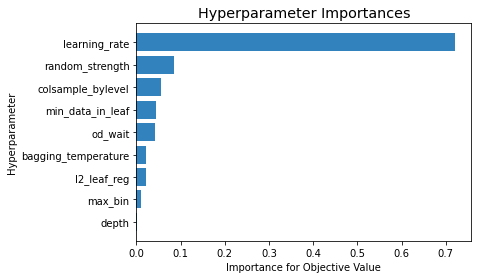

In [10]:
optuna.visualization.matplotlib.plot_param_importances(cat_study);

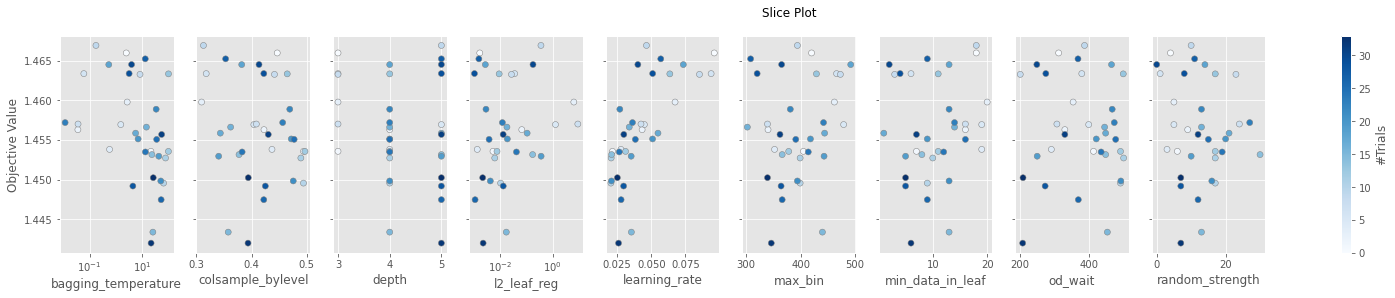

In [11]:
optuna.visualization.matplotlib.plot_slice(cat_study);

In [ ]:
# with open('../pickle/cat_best_hyperparams.pickle', 'rb') as fw:
#     cat_best_hyperparams = pickle.load(fw)

In [ ]:
lucky_seeds = np.random.randint(0, 1000, num_seed_tr)

for i, seed in enumerate(lucky_seeds):

    kfold = StratifiedKFold(n_splits=splits_tr, random_state=seed, shuffle=True) # CV 늘려가면서 하기
    cv = np.zeros(rows_train)
    pred_test = np.zeros(rows_test)

    for n, (train_idx, val_idx) in enumerate(kfold.split(train_x, train_y)):
        
        x_train, x_val = train_x.iloc[train_idx], train_x.iloc[val_idx]
        y_train, y_val = train_y.iloc[train_idx].values.ravel(), train_y.iloc[val_idx].values.ravel()

        catmodel = CatBoostRegressor(**cat_best_hyperparams)
        catmodel.fit(x_train, y_train, eval_set=[(x_val, y_val)], early_stopping_rounds=50, verbose=False)
        
        cv[val_idx] = catmodel.predict(x_val)
        pred_test += catmodel.predict(test_x) / splits_tr
        
    pred_dict['cat'+str(seed)] = cv
    pred_test_dict['cat'+str(seed)] = pred_test
    print(f'seed {seed}', 'mean_absolute_error :', mean_absolute_error(train_y, cv))

In [22]:
pred_dict

{'cat770': array([11.08437257,  6.94546213, 12.78826299, ...,  8.49291613,
         8.88674424, 10.7331683 ]),
 'cat578': array([11.63693304,  6.86849644, 12.67527961, ...,  8.51882925,
         8.38652705, 10.70974132]),
 'cat705': array([11.5667634 ,  7.06705722, 12.90497162, ...,  8.16279063,
         8.52242221, 10.84109921]),
 'cat913': array([11.5427544 ,  6.94804216, 13.2814054 , ...,  8.33139211,
         8.56396321, 10.7550864 ]),
 'cat201': array([11.78654287,  6.99195319, 12.93905492, ...,  8.49790388,
         8.55650572, 10.81171197])}

In [27]:
pred = (pred_dict['cat770'] + pred_dict['cat578'] + pred_dict['cat201']) / 3

In [30]:
pred_test = (pred_test_dict['cat770'] + pred_test_dict['cat578'] + pred_test_dict['cat201']) / 3

In [28]:
mean_absolute_error(train_y, np.round(pred))

1.4086193136472467

# 3. Export

In [ ]:
def sort_dict(model, pred_dict, pred_test_dict):
    pred_dict_local = {}
    for key, value in pred_dict.items():
        if model in key:
            pred_dict_local[key]=value

    pred_test_dict_local = {}
    for key, value in pred_test_dict.items():
        if model in key:
            pred_test_dict_local[key]=value

    pred_dict_new_local = dict(sorted(
        pred_dict_local.items(), 
        key=lambda x:mean_absolute_error((train_y), list(x[1])), reverse=False)[:sel_seed])
    pred_test_dict_new_local = {}
    for key, value in pred_dict_new_local.items():
        pred_test_dict_new_local[key]=pred_test_dict_local[key]
        
    return pred_dict_new_local, pred_test_dict_new_local

In [ ]:
def save_dict(model, pred_dict, pred_test_dict):
    with open('../pickle/pred_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_dict, fw)
    with open('../pickle/pred_test_dict_'+model+'.pickle', 'wb') as fw:
        pickle.dump(pred_test_dict, fw)

In [ ]:
pred_dict_cat, pred_test_dict_cat = sort_dict('cat', pred_dict, pred_test_dict)
save_dict('cat', pred_dict_cat, pred_test_dict_cat)

In [ ]:
with open('../pickle/autosklearn_cv10_seed0.pickle', 'rb') as fw:
    pred_test_2 = pickle.load(fw)

In [31]:
submission.Target = np.round(pred_test).astype(int)

In [32]:
submission_name = '20220329'
submission_number = '3'
submission.to_csv(f'../submission/{submission_name}-{submission_number}.csv', index = False)